In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math
import pybroom as pb
import numpy as np

def TC(x, ystress=1.0, eta_bg=0.1, gammadot_crit=0.1):
    """Three component model
    Note:
    .. math::
       \sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma
    Args:
        ystress: yield stress [Pa]
        eta_bg : Background viscosity [Pa s]
        gammadot_crit : Critical shear rate [1/s]
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + ystress * (x / gammadot_crit) ** 0.5 + eta_bg * x


TC_model = lmfit.Model(TC, prefix="TC_")
""" Lmfit model from equation :meth:`rheofit.models.TC`
Note:
TC_model.set_param_hint('ystress', min=0)
TC_model.set_param_hint('eta_bg', min=0, vary=True)
TC_model.set_param_hint('gammadot_crit', min=0)
"""
TC_model.model_expression = Math(
    "\sigma=\sigma_y+\sigma_y\cdot(\dot\gamma/\dot\gamma_c)^{0.5}+\eta_{bg}\cdot\dot\gamma"
)

TC_model.set_param_hint("ystress", min=0)
TC_model.set_param_hint("eta_bg", min=0, vary=True)
TC_model.set_param_hint("gammadot_crit", min=0)

def HB(x, ystress=1.0, K=1.0, n=0.5):
    """Hershel-Bulkley Model
    Note:
    .. math::
       \sigma= \sigma_y + K \cdot \dot\gamma^n
    Args:
        ystress: yield stress [Pa]
        K : Consistency index [Pa s^n]
        n : Shear thinning index []
    Returns:
        stress : Shear Stress, [Pa]
    """
    return ystress + K * x ** n


HB_model = lmfit.Model(HB, prefix="HB_")
""" Lmfit model from equation :meth:`rheofit.models.HB`
Note:
HB_model.set_param_hint('ystress', min=0)
HB_model.set_param_hint('K', min=0, vary=True)
HB_model.set_param_hint('n', min=0.0,max=1,vary=True)
"""

HB_model.model_expression = Math("\sigma=\sigma_y+K\cdot\dot\gamma^n")

HB_model.set_param_hint("ystress", min=0)
HB_model.set_param_hint("K", min=0, vary=True)
HB_model.set_param_hint("n", min=0.0, max=1, vary=True)



In [101]:
data_fig_6=pd.read_csv('figure_6.csv', header=[0,1])
data_fig_9=pd.read_csv('figure_9.csv', header=[0,1])

In [104]:
sample_label_list_fig6=list(data_fig_6.columns.get_level_values(0).unique())
sample_label_list_fig9=list(data_fig_9.columns.get_level_values(0).unique())


Text(0.5, 0.98, 'Fig6-Fig9 data from 10.1039/d0sm01196g')

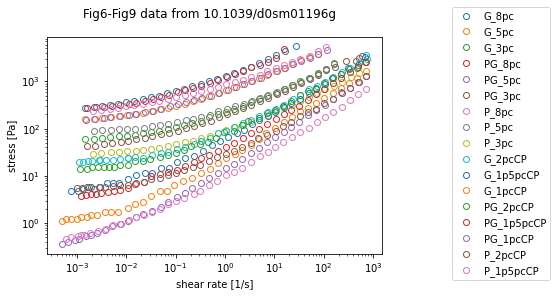

In [119]:
fig, ax = plt.subplots()

for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.set_xlabel('shear rate [1/s]')
ax.set_ylabel('stress [Pa]')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 data from 10.1039/d0sm01196g')

Text(0.5, 0.98, 'Fig6-Fig9 data + HB_fit from 10.1039/d0sm01196g')

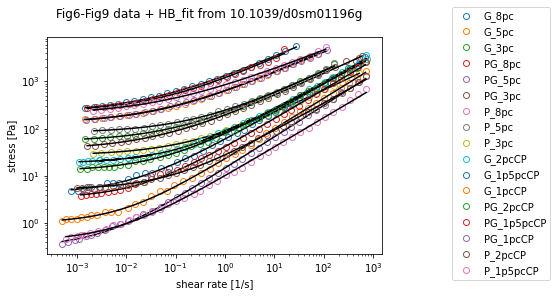

In [166]:
fig, ax = plt.subplots()
fit_res_dict_HB={}


for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    fit=HB_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    fit_res_dict_HB[sample_label]=fit

    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.plot(data['X'],fit.eval(x=data['X']), color='black')

    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    fit=HB_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    fit_res_dict_HB[sample_label]=fit

    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.plot(data['X'],fit.eval(x=data['X']), color='black')
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.set_xlabel('shear rate [1/s]')
ax.set_ylabel('stress [Pa]')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 data + HB_fit from 10.1039/d0sm01196g')

In [167]:
fit_res_table_HB=pb.tidy(fit_res_dict_HB).pivot(index='key',columns='name', values='value')
fit_res_table_HB


name,HB_K,HB_n,HB_ystress
key,,,
G_1p5pcCP,56.171713,0.596945,4.298496
G_1pcCP,22.216268,0.647045,1.002511
G_2pcCP,66.507039,0.578215,18.634750
G_3pc,167.039502,0.497577,54.049421
G_5pc,500.091098,0.468999,132.934082
G_8pc,1106.240227,0.459659,222.470363
PG_1p5pcCP,38.456793,0.620852,3.386230
PG_1pcCP,14.426772,0.666250,0.317306
PG_2pcCP,66.601278,0.561477,12.726364


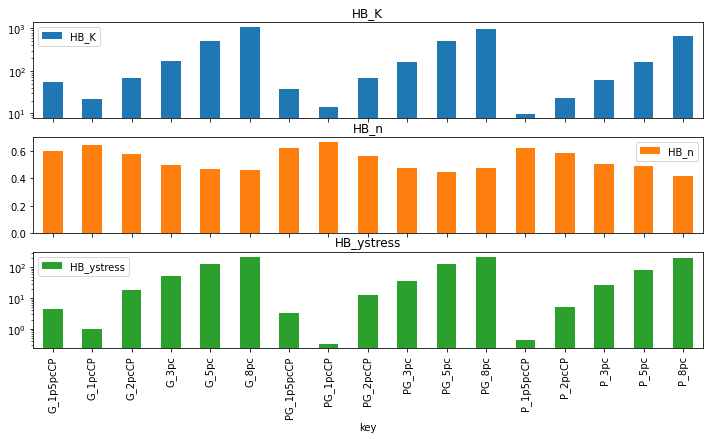

In [248]:
fit_res_table_HB.plot(subplots=True, kind='bar', figsize=(12, 6), logy=True);
plt.gcf().get_axes()[1].set_yscale('linear')

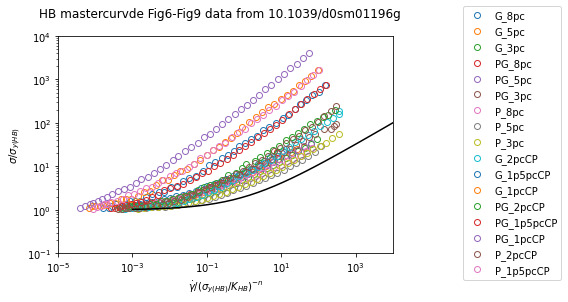

In [242]:
fig, ax = plt.subplots()


for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    fit=HB_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    
    x_rescale=(fit.best_values['HB_ystress']/fit.best_values['HB_K'])**(-fit.best_values['HB_n'])
    
    ax.plot(data['X']/x_rescale,data['Y']/fit.best_values['HB_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    fit=HB_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')

    x_rescale=(fit.best_values['HB_ystress']/fit.best_values['HB_K'])**(-fit.best_values['HB_n'])

    ax.plot(data['X']/x_rescale,data['Y']/fit.best_values['HB_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.plot(np.logspace(-3,8),1+np.logspace(-3,8)**0.5, color='black')


ax.set_xlabel('$\dot\gamma / (\sigma_{y(HB)}/K_{HB})^{-n}$')
ax.set_ylabel('$\sigma / \sigma_{y(HB)}$')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('HB mastercurvde Fig6-Fig9 data from 10.1039/d0sm01196g')
ax.set_xlim(0.00001,1E4)
ax.set_ylim(0.1,1E4)
fig.savefig('HB mastercurve.jpg',bbox_inches = "tight")

Text(0.5, 0.98, 'Fig6-Fig9 data from 10.1039/d0sm01196g')

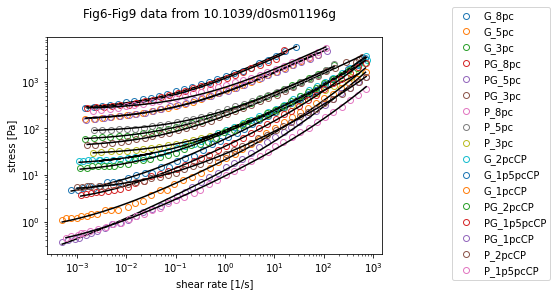

In [171]:
fig, ax = plt.subplots()
fit_res_dict_TC={}

for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    fit=TC_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    fit_res_dict_TC[sample_label]=fit

    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.plot(data['X'],fit.eval(x=data['X']), color='black')

    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    fit=TC_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    fit_res_dict_TC[sample_label]=fit

    ax.plot(data['X'],data['Y'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.plot(data['X'],fit.eval(x=data['X']), color='black')
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.set_xlabel('shear rate [1/s]')
ax.set_ylabel('stress [Pa]')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 data from 10.1039/d0sm01196g')

In [172]:
fit_res_table_TC=pb.tidy(fit_res_dict_TC).pivot(index='key',columns='name', values='value')
fit_res_table_TC


name,TC_eta_bg,TC_gammadot_crit,TC_ystress
key,,,
G_1p5pcCP,2.933950e+00,0.003269,3.060686
G_1pcCP,2.125658e+00,0.000914,0.564237
G_2pcCP,2.001051e+00,0.056613,16.470222
G_3pc,1.277320e-01,0.108682,54.506457
G_5pc,2.037161e-08,0.097191,145.373901
G_8pc,6.345987e-08,0.057976,251.275931
PG_1p5pcCP,2.764240e+00,0.003909,2.277263
PG_1pcCP,1.868875e+00,0.000060,0.084512
PG_2pcCP,1.498216e+00,0.025819,11.034838


(0.001, 10.821660471890727)

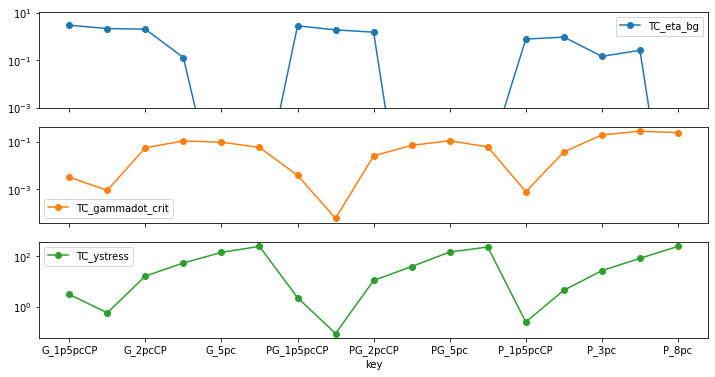

In [236]:
fit_res_table_TC.plot(subplots=True, figsize=(12, 6), marker='o', logy=True);
plt.gcf().get_axes()[0].set_ylim(0.001)

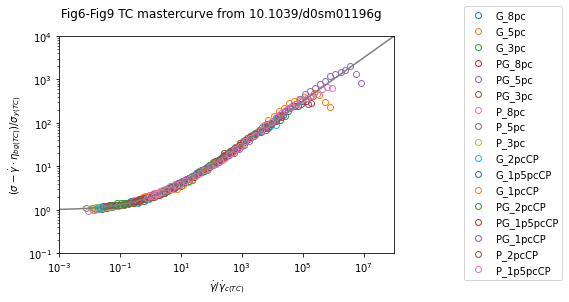

In [244]:
fig, ax = plt.subplots()

for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    fit=TC_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    
    x_rescale=fit.best_values['TC_gammadot_crit']

    ax.plot(data['X']/x_rescale,(data['Y']-data['X']*fit.best_values['TC_eta_bg'])/fit.best_values['TC_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    fit=TC_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')

    x_rescale=fit.best_values['TC_gammadot_crit']

    ax.plot(data['X']/x_rescale,(data['Y']-data['X']*fit.best_values['TC_eta_bg'])/fit.best_values['TC_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.plot(np.logspace(-3,8),1+np.logspace(-3,8)**0.5)

ax.set_xlabel('$\dot\gamma/\dot\gamma_{c(TC)}$')
ax.set_ylabel('$(\sigma - \dot\gamma \cdot \eta_{bg(TC)}) / \sigma_{y(TC)}$')
ax.set_xlim(0.001,1E8)
ax.set_ylim(0.1,1E4)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 TC mastercurve from 10.1039/d0sm01196g')

fig.savefig('TC mastercurve.jpg', bbox_inches = "tight")

Text(0.5, 0.98, 'Fig6-Fig9 TC mastercurve from 10.1039/d0sm01196g')

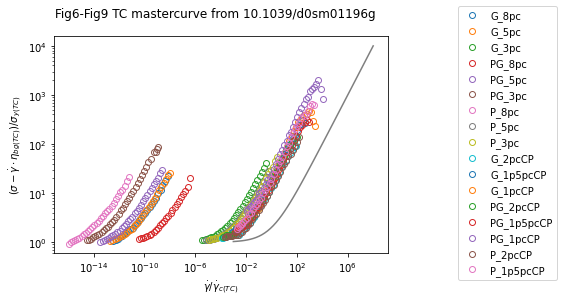

In [243]:
fig, ax = plt.subplots()

for sample_label in sample_label_list_fig6:
    data=data_fig_6.loc[:,data_fig_6.columns.get_level_values(0)==sample_label][sample_label]
    fit=TC_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')
    
    x_rescale=fit.best_values['TC_ystress']/fit.best_values['TC_eta_bg']

    ax.plot(data['X']/x_rescale,(data['Y']-data['X']*fit.best_values['TC_eta_bg'])/fit.best_values['TC_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

for sample_label in sample_label_list_fig9:
    data=data_fig_9.loc[:,data_fig_9.columns.get_level_values(0)==sample_label][sample_label]
    fit=TC_model.fit(data['Y'],x=data['X'],weights=1/data['Y'], nan_policy='omit')

    x_rescale=fit.best_values['TC_ystress']/fit.best_values['TC_eta_bg']

    ax.plot(data['X']/x_rescale,(data['Y']-data['X']*fit.best_values['TC_eta_bg'])/fit.best_values['TC_ystress'], marker='o', linestyle= 'None', mfc='None', label=sample_label)
    ax.set_yscale('log')
    ax.set_xscale('log')

ax.plot(np.logspace(-3,8),1+np.logspace(-3,8)**0.5)

ax.set_xlabel('$\dot\gamma/\dot\gamma_{c(TC)}$')
ax.set_ylabel('$(\sigma - \dot\gamma \cdot \eta_{bg(TC)}) / \sigma_{y(TC)}$')

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Fig6-Fig9 TC mastercurve from 10.1039/d0sm01196g')